In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Constants
c = 3e8  # Speed of light (m/s)
f = 97e9  # Frequency (Hz)
wavelength = c / f  # Wavelength (m)
omega = 15.7e-3  # Beam width at phase plate (m)
distance = 500e-3  # Distance between phase plate and image plane (500 mm)


In [3]:
# Grid setup for 500 mm x 500 mm (same for phase plate and image plane)
physical_size = 500e-3  # 500 mm in meters
grid_size = 128  # Grid resolution

# Create phase plane grid (500 mm x 500 mm)
x = np.linspace(-physical_size / 2, physical_size / 2, grid_size)
y = np.linspace(-physical_size / 2, physical_size / 2, grid_size)
X, Y = np.meshgrid(x, y)

In [4]:
# Target image plane grid (same size as phase plate grid, but target image is smaller within it)
target_width, target_height = 60e-3 , 384e-3 # Target image size (384 mm x 6 mm)
target_image = np.zeros((grid_size, grid_size))

# Set the target image intensity inside the small rectangle (within the larger grid)
rect_x_indices = (X >= -target_width / 2) & (X <= target_width / 2)
rect_y_indices = (Y >= -target_height / 2) & (Y <= target_height / 2)
target_image[rect_x_indices & rect_y_indices] = 1  # Uniform intensity within target rectangle

# def create_plus_sign(size, line_thickness, grid_length):
#     target_intensity = np.zeros((size, size))
#     center_x = size // 2
#     center_y = size // 2

#     # Calculate the half-length for the cross arms in physical dimensions
#     half_length = (2 / grid_length) * (size // 2)
#     line_thickness = int(line_thickness)

#     # Horizontal line
#     target_intensity[center_x - line_thickness//2 : center_x + line_thickness//2 + 1, center_y - int(half_length): center_y + int(half_length) + 1] = 1

#     # Vertical line
#     target_intensity[center_x - int(half_length): center_x + int(half_length) + 1, center_y - line_thickness//2 : center_y + line_thickness//2 + 1] = 1

#     return target_intensity
    
# line_thickness = grid_size // 16
# target_image = create_plus_sign(grid_size, line_thickness, physical_size)

# Initial Gaussian beam profile (centered in the same grid)
r_sq = X**2 + Y**2
E = (1 / (2 * np.pi * omega**2)) * np.exp(-r_sq / (4 * omega**2)) * np.exp(1j * (2 * np.pi / wavelength) * (np.sqrt(distance**2 + r_sq) - distance))
amplitude = np.abs(E)
phase = np.angle(E)

# Normalize the amplitude of the initial beam
max_intensity = np.max(amplitude)  # Find the maximum intensity
normalized_amplitude = amplitude / max_intensity  # Normalize amplitude to range [0, 1]

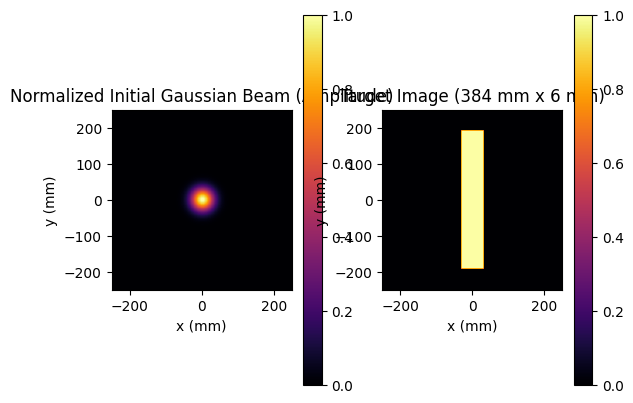

In [5]:
# Visualization of the initial beam and target
plt.subplot(121)
plt.imshow(normalized_amplitude, extent=[-250, 250, -250, 250], cmap='inferno')
plt.title('Normalized Initial Gaussian Beam (Amplitude)')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.colorbar()

plt.subplot(122)
plt.imshow(target_image, extent=[-250, 250, -250, 250], cmap='inferno')
plt.title('Target Image (384 mm x 6 mm)')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.colorbar()

plt.show()

In [6]:
def forward_propagation(amplitude, phase, X, Y, X_plane, Y_plane, wavelength, distance):
    k = 2 * np.pi / wavelength  # wave number
    E_d = np.zeros(X_plane.shape, dtype=complex)  # Initialize electric field in the image plane

    # Loop over all points in the diffraction plane
    for i in range(X.shape[0]):
        for j in range(Y.shape[1]):
            # Calculate the distance r between (x, y) in the diffraction plane and all points (x', y') in the image plane
            r = np.sqrt((X[i, j] - X_plane)**2 + (Y[i, j] - Y_plane)**2 + distance**2)  # Account for the distance between the plates
            
            # Avoid divide-by-zero for r = 0 (set r to a small number)
            r[r == 0] = 1e-12
            
            # Compute electric field contribution for each point using Huygens principle
            E_d += (amplitude[i, j] / r) * np.exp(-1j * k * r + 1j * phase[i, j])
    
    return E_d


In [7]:
def intensity_constraint(E_image, target_intensity):
    current_amplitude = np.abs(E_image)
    current_phase = np.angle(E_image)
    adjusted_amplitude = np.sqrt(target_intensity)  # Adjust amplitude
    E_image_adjusted = adjusted_amplitude * np.exp(1j * current_phase)
    return E_image_adjusted

In [8]:
def backward_propagation(E_image_adjusted, X, Y, X_plane, Y_plane, wavelength, distance):
    k = 2 * np.pi / wavelength  # wave number
    E_backward = np.zeros(X.shape, dtype=complex)  # Initialize electric field in the diffraction plane
    
    # Loop over all points in the image plane
    for i in range(X_plane.shape[0]):
        for j in range(Y_plane.shape[1]):
            # Calculate the distance r between (x', y') in the image plane and all points (x, y) in the diffraction plane
            r = np.sqrt((X - X_plane[i, j])**2 + (Y - Y_plane[i, j])**2 + distance**2)
            
            # Avoid divide-by-zero for r = 0 (set r to a small number)
            r[r == 0] = 1e-12
            
            # Compute the angle Omega
            Omega = np.arctan2(np.sqrt((X - X_plane[i, j])**2 + (Y - Y_plane[i, j])**2), distance)
            
            # Compute the backward electric field contribution for each point, including the angular term
            E_backward += (E_image_adjusted[i, j] * (1 + np.cos(Omega)) / r) * np.exp(1j * k * r)
    
    return E_backward


In [10]:
# GS Algorithm parameters
num_iterations = 100
phase_plate_size = 500e-3

# Create phase plate grid
phase_plate_x = np.linspace(-phase_plate_size / 2, phase_plate_size / 2, grid_size)
phase_plate_y = np.linspace(-phase_plate_size / 2, phase_plate_size / 2, grid_size)
X_phase, Y_phase = np.meshgrid(phase_plate_x, phase_plate_y)

# Initialize phase profile using the IFT of the target field
initial_field = np.fft.ifft2(target_image)  # Inverse Fourier Transform of the target image intensity
initial_phase_profile = np.angle(initial_field)  # Extract the phase from the initial field

# GS Iteration
phase_profile = initial_phase_profile.copy()
for iteration in range(num_iterations):
    # Forward propagation (from phase plate to image plane)
    E_image = forward_propagation(normalized_amplitude, phase_profile, X_phase, Y_phase, X, Y, wavelength, distance)
    
    # Apply intensity constraint to match the target image intensity
    E_image_adjusted = intensity_constraint(E_image, target_image)
    
    # Backward propagation (from image plane back to phase plate)
    E_backward = backward_propagation(E_image_adjusted, X, Y, X_phase, Y_phase, wavelength, distance)
    
    # Update phase profile by taking the phase of the backward-propagated field
    phase_profile = np.angle(E_backward)
    amplitude_profile = np.abs(E_backward)

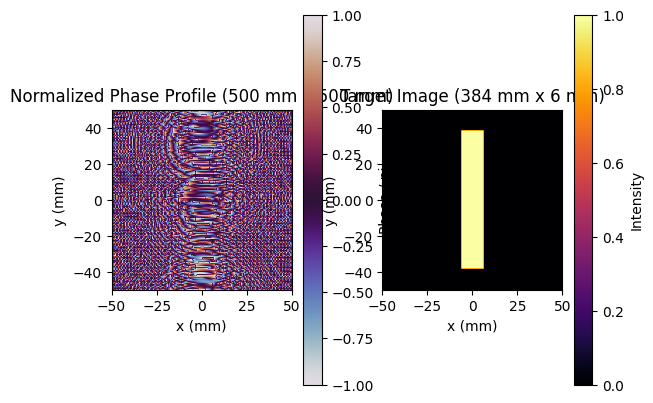

In [12]:
# Recalculate phase profile wrapped to the range -pi to +pi
phase_profile_wrapped = np.angle(np.exp(1j * phase_profile))

# Normalize the phase profile
normalized_phase_profile = phase_profile_wrapped / np.pi

# Visualization
plt.subplot(121)
plt.imshow(normalized_phase_profile, extent=[-50, 50, -50, 50], cmap='twilight', vmin=-1, vmax=1)
plt.title('Normalized Phase Profile (500 mm x 500 mm)')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.colorbar(label='Phase / pi')

plt.subplot(122)
plt.imshow(target_image, extent=[-50, 50, -50, 50], cmap='inferno')
plt.title('Target Image (384 mm x 6 mm)')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.colorbar(label='Intensity')

plt.show()

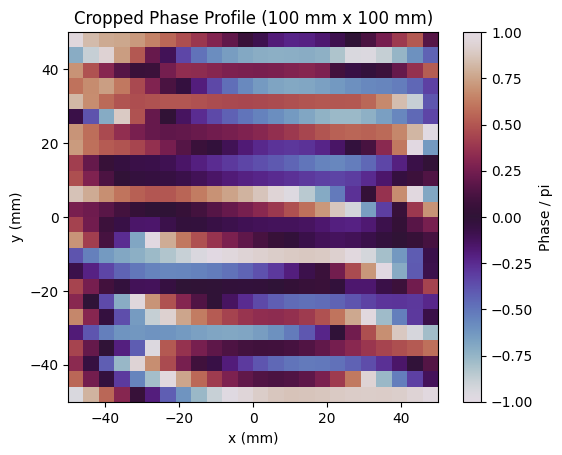

In [13]:
# Calculate the crop indices for a 100 mm x 100 mm section from the center
crop_size = int((100 / 500) * grid_size)  # Calculate the number of points that correspond to 100 mm
center = grid_size // 2  # Center index
start_idx = center - crop_size // 2
end_idx = center + crop_size // 2

# Extract the central 100 mm x 100 mm portion of the phase profile
central_phase_profile = normalized_phase_profile[start_idx:end_idx, start_idx:end_idx]

# Visualization of the cropped phase profile
plt.imshow(central_phase_profile, extent=[-50, 50, -50, 50], cmap='twilight', vmin=-1, vmax=1)
plt.title('Cropped Phase Profile (100 mm x 100 mm)')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.colorbar(label='Phase / pi')
plt.show()


In [1]:
from stl import mesh
from mpl_toolkits import mplot3d
# Constants (as used in your previous code)
wavelength = 3.09e-3  # Wavelength in meters (for 97 GHz)
n = 1.6  # Refractive index of polyamide

# Phase to thickness conversion
thickness = (normalized_phase_profile * wavelength) / (2 * (n - 1))

# Create a 3D surface using the thickness
x_vals = np.linspace(-phase_plate_size / 2, phase_plate_size / 2, grid_size)
y_vals = np.linspace(-phase_plate_size / 2, phase_plate_size / 2, grid_size)
X, Y = np.meshgrid(x_vals, y_vals)
Z = thickness  # Use the calculated thickness as the height

# Visualize the phase plate as a 3D surface (optional)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_title('3D Phase Plate')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Thickness (m)')
plt.show()

# Convert the 3D surface to STL file
def create_stl_file(x_vals, y_vals, z_vals, filename):
    # Create a list of faces (triangles)
    faces = []
    for i in range(grid_size - 1):
        for j in range(grid_size - 1):
            # Create two triangles for each square in the grid
            v1 = [x_vals[i], y_vals[j], z_vals[i, j]]
            v2 = [x_vals[i + 1], y_vals[j], z_vals[i + 1, j]]
            v3 = [x_vals[i], y_vals[j + 1], z_vals[i, j + 1]]
            v4 = [x_vals[i + 1], y_vals[j + 1], z_vals[i + 1, j + 1]]
            
            # First triangle (v1, v2, v3)
            faces.append([v1, v2, v3])
            
            # Second triangle (v2, v4, v3)
            faces.append([v2, v4, v3])
    
    # Convert to numpy array
    faces = np.array(faces)
    
    # Create a mesh object
    phase_plate_mesh = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
    
    for i, face in enumerate(faces):
        phase_plate_mesh.vectors[i] = face
    
    # Save the mesh to an STL file
    phase_plate_mesh.save(filename)

# Specify the filename and save the STL file
stl_filename = "phase_plate.stl"
create_stl_file(x_vals, y_vals, Z, stl_filename)

print(f"STL file '{stl_filename}' has been created.")


NameError: name 'normalized_phase_profile' is not defined

## 2ND TRIES

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Constants and initial parameters
c = 3e8  # Speed of light (m/s)
f = 97e9  # Frequency (Hz)
wavelength = c / f  # Wavelength (m)
beam_width = 500e-3  # Beam width at the phase plate (in meters)
phase_plate_size = 0.2  # Phase plate size (100 mm x 100 mm)
image_plane_size = 0.2  # Image plane size (500 mm x 500 mm)
distance_source_to_plate = 75e-3  # Distance from source to phase plate (in meters)
distance_plate_to_image = 500e-3  # Distance from phase plate to image plane (in meters)

In [8]:
# Set grid sizes
grid_size = 50

# Spatial grid for phase plate (100 mm x 100 mm)
x_plate = np.linspace(-phase_plate_size / 2, phase_plate_size / 2, grid_size)
y_plate = np.linspace(-phase_plate_size / 2, phase_plate_size / 2, grid_size)
X_plate, Y_plate = np.meshgrid(x_plate, y_plate)

# Spatial grid for image plane (500 mm x 500 mm)
x_image = np.linspace(-image_plane_size / 2, image_plane_size / 2, grid_size)
y_image = np.linspace(-image_plane_size / 2, image_plane_size / 2, grid_size)
X_image, Y_image = np.meshgrid(x_image, y_image)

In [9]:
# Initialize Gaussian source
def gaussian_beam_profile(X, Y, wavelength, beam_width, distance):
    phase_term = np.exp(1j * (2 * np.pi / wavelength) * (np.sqrt(distance**2 + X**2 + Y**2) - distance))
    amplitude_term = (1 / (2 * np.pi * beam_width**2)) * np.exp(-(X**2 + Y**2) / (4 * beam_width**2))
    return amplitude_term * phase_term

In [10]:
Source = gaussian_beam_profile(X_plate, Y_plate, wavelength, beam_width, distance_source_to_plate)
Source /= np.max(np.abs(Source))

target_amplitude = np.zeros((grid_size, grid_size))
plus_width = 0.02  # Width of the plus arms (in meters)
plus_length = 0.25  # Length of the plus arms (in meters)
target_x = (np.abs(Y_image) <= plus_width / 2) & (np.abs(X_image) <= plus_length / 2)
target_y = (np.abs(X_image) <= plus_width / 2) & (np.abs(Y_image) <= plus_length / 2)
target_amplitude[target_x | target_y] = 1
Target = target_amplitude / np.max(target_amplitude)

In [11]:
# Huygens-based forward propagation
def huygens_forward(E_phase, X_src, Y_src, X_dest, Y_dest, wavelength):
    k = 2 * np.pi / wavelength
    E_dest = np.zeros(X_dest.shape, dtype=complex)
    
    for i in range(X_dest.shape[0]):
        for j in range(X_dest.shape[1]):
            r = np.sqrt((X_dest[i, j] - X_src)**2 + (Y_dest[i, j] - Y_src)**2 + distance_plate_to_image**2)
            E_contrib = E_phase / r * np.exp(-1j * k * r)
            E_dest[i, j] = np.sum(E_contrib)
    
    return E_dest

In [12]:
# Backward propagation (image to phase plate)
def huygens_backward(E_image, X_dest, Y_dest, X_src, Y_src, wavelength):
    k = 2 * np.pi / wavelength
    E_src = np.zeros(X_src.shape, dtype=complex)
    
    for i in range(X_src.shape[0]):
        for j in range(X_src.shape[1]):
            r = np.sqrt((X_src[i, j] - X_dest)**2 + (Y_src[i, j] - Y_dest)**2 + distance_plate_to_image**2)
            E_contrib = E_image / r * np.exp(-1j * k * r)
            E_src[i, j] = np.sum(E_contrib)
    
    return E_src

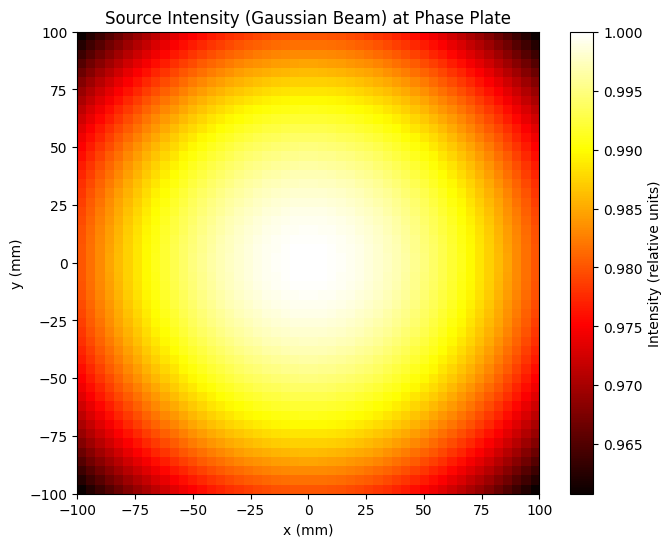

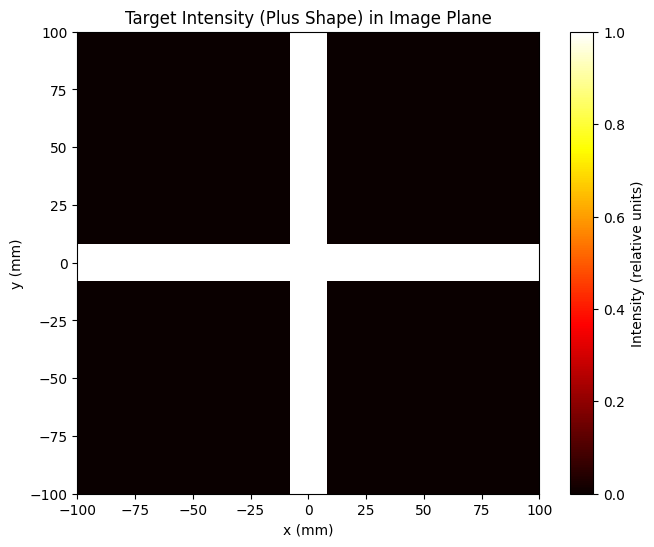

In [13]:
# Plot the source (initial Gaussian beam) intensity
plt.figure(figsize=(8, 6))
plt.imshow(np.abs(Source)**2, extent=(-phase_plate_size/2*1e3, phase_plate_size/2*1e3, -phase_plate_size/2*1e3, phase_plate_size/2*1e3), cmap="hot")
plt.title("Source Intensity (Gaussian Beam) at Phase Plate")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar(label="Intensity (relative units)")
plt.show()

# Plot the target (plus-shaped target image) intensity
plt.figure(figsize=(8, 6))
plt.imshow(Target, extent=(-image_plane_size/2*1e3, image_plane_size/2*1e3, -image_plane_size/2*1e3, image_plane_size/2*1e3), cmap="hot")
plt.title("Target Intensity (Plus Shape) in Image Plane")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar(label="Intensity (relative units)")
plt.show()


In [14]:
# Define the quadratic phase term function
k = 2 * np.pi / wavelength  # Wave number

def quadratic_phase_term(X, Y, wavelength, z):
    return np.exp(1j * k * z) * np.exp(1j * np.pi * (X**2 + Y**2) / (wavelength * z))

In [15]:
# Initialize phase profile
random_phase = np.exp(1j * 2 * np.pi * np.random.rand(grid_size, grid_size))
A = Target * random_phase

# Gerchberg-Saxton algorithm with Huygens propagation
max_iterations = 200
error_threshold = 0.1
error = float('inf')
iteration = 0
# error > error_threshold and
while iteration < max_iterations:
    # Forward propagation from phase plate to image plane
    E_image_plane = huygens_forward(A, X_plate, Y_plate, X_image, Y_image, wavelength)
    
    # Apply target intensity constraint
    E_image_plane = Target * np.exp(1j * np.angle(E_image_plane))
    
    # Backward propagation from image plane to phase plate
    E_phase_plate = huygens_backward(E_image_plane, X_image, Y_image, X_plate, Y_plate, wavelength)
    
    # Update phase profile
    A = np.abs(Source) * np.exp(1j * np.angle(E_phase_plate))
    
    # Calculate error
    current_amplitude = np.abs(E_image_plane)
    error = np.mean((current_amplitude - Target)**2)
    print(f"Iteration {iteration}: Error = {error:.4f}")
    
    iteration += 1

# Retrieve final phase profile
Retrieved_Phase = np.angle(A)

Iteration 0: Error = 0.0000
Iteration 1: Error = 0.0000
Iteration 2: Error = 0.0000
Iteration 3: Error = 0.0000
Iteration 4: Error = 0.0000
Iteration 5: Error = 0.0000
Iteration 6: Error = 0.0000
Iteration 7: Error = 0.0000
Iteration 8: Error = 0.0000
Iteration 9: Error = 0.0000
Iteration 10: Error = 0.0000
Iteration 11: Error = 0.0000
Iteration 12: Error = 0.0000
Iteration 13: Error = 0.0000
Iteration 14: Error = 0.0000
Iteration 15: Error = 0.0000
Iteration 16: Error = 0.0000
Iteration 17: Error = 0.0000
Iteration 18: Error = 0.0000
Iteration 19: Error = 0.0000
Iteration 20: Error = 0.0000
Iteration 21: Error = 0.0000
Iteration 22: Error = 0.0000
Iteration 23: Error = 0.0000
Iteration 24: Error = 0.0000
Iteration 25: Error = 0.0000
Iteration 26: Error = 0.0000
Iteration 27: Error = 0.0000
Iteration 28: Error = 0.0000
Iteration 29: Error = 0.0000
Iteration 30: Error = 0.0000
Iteration 31: Error = 0.0000
Iteration 32: Error = 0.0000
Iteration 33: Error = 0.0000
Iteration 34: Error = 0.

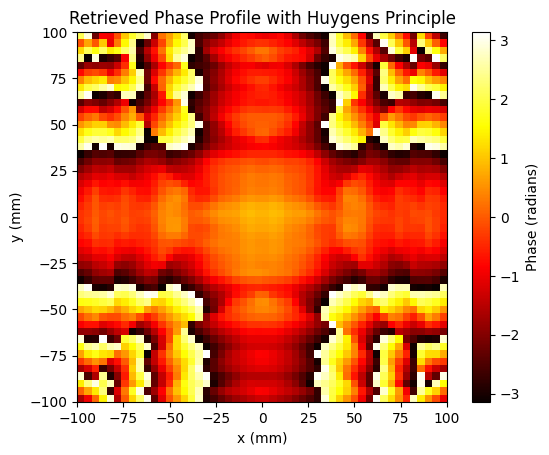

In [16]:
# Plot the final phase profile
plt.imshow(Retrieved_Phase, extent=(-phase_plate_size/2*1e3, phase_plate_size/2*1e3, -phase_plate_size/2*1e3, phase_plate_size/2*1e3), cmap="hot")
plt.title("Retrieved Phase Profile with Huygens Principle")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar(label="Phase (radians)")
plt.show()

In [1]:
# Apply phase plate to initial source
E_phase_plate = Source * np.exp(1j * Retrieved_Phase)

# Forward propagate to observe final generated intensity
E_image_projected = huygens_forward(E_phase_plate, X_plate, Y_plate, X_image, Y_image, wavelength)
intensity_image_projected = np.abs(E_image_projected)**2 / np.max(np.abs(E_image_projected)**2)

# Plot generated intensity
plt.imshow(intensity_image_projected, extent=(-image_plane_size/2*1e3, image_plane_size/2*1e3, -image_plane_size/2*1e3, image_plane_size/2*1e3), cmap="hot")
plt.title("Generated Image Intensity in Image Plane with Huygens Propagation")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar(label="Intensity (relative units)")
plt.show()

NameError: name 'Source' is not defined

## Seyed Code

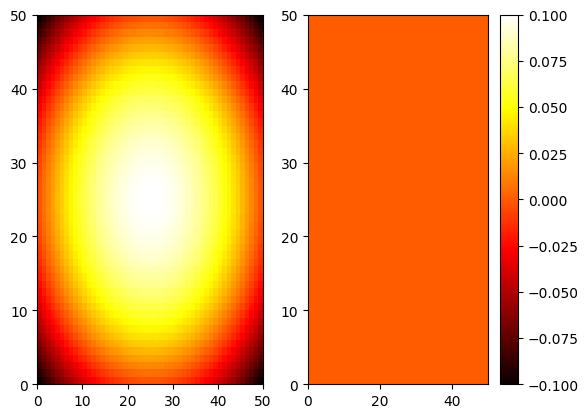

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 85.31it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 84.89it/s]


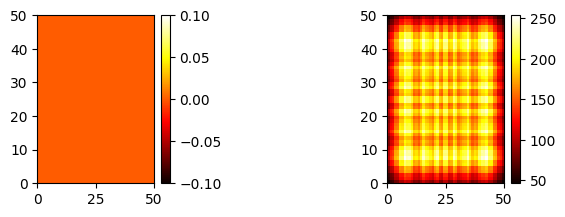

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.39it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 83.77it/s]


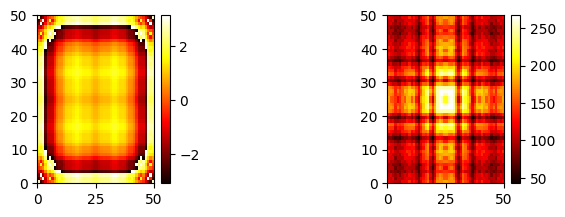

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 82.73it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 83.59it/s]


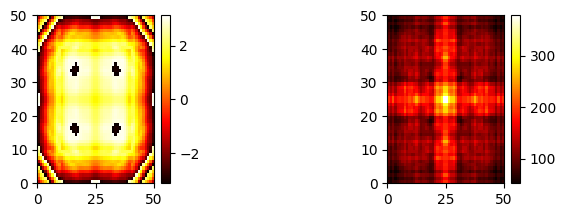

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.38it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.81it/s]


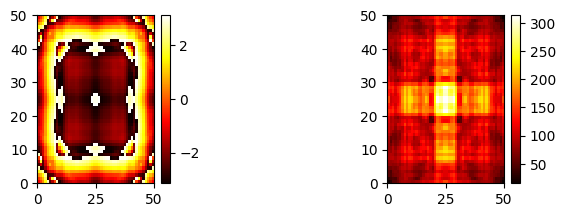

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 82.61it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.82it/s]


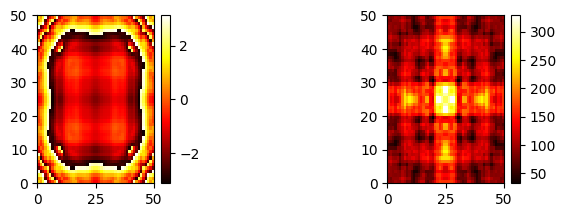

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 71.37it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.17it/s]


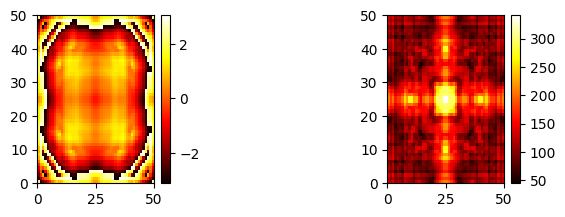

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 83.30it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.21it/s]


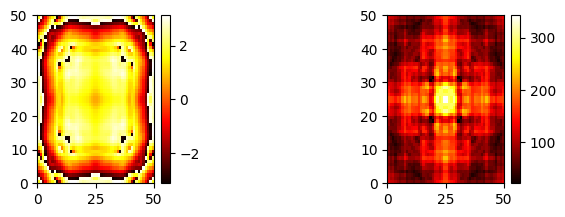

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 82.47it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.08it/s]


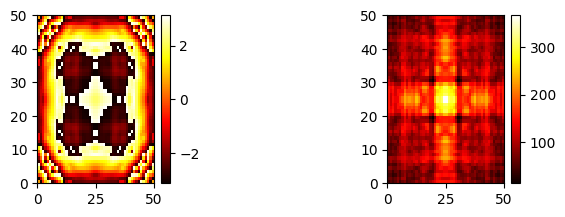

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.72it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 82.93it/s]


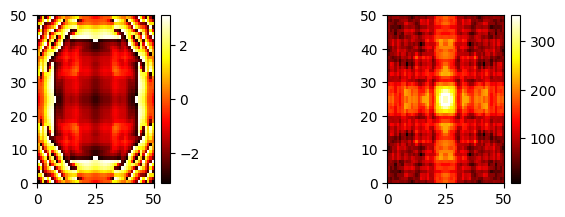

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.51it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.43it/s]


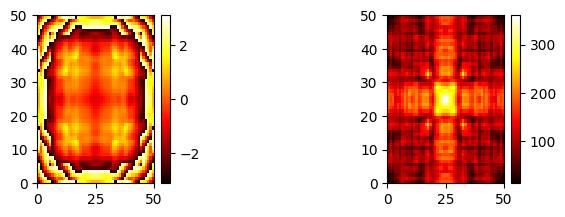

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.51it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 82.90it/s]


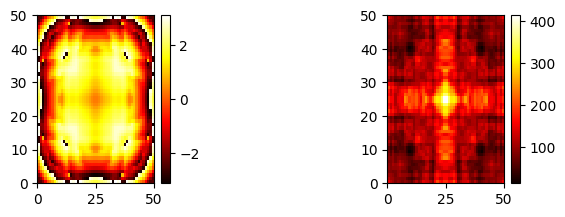

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 83.17it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.45it/s]


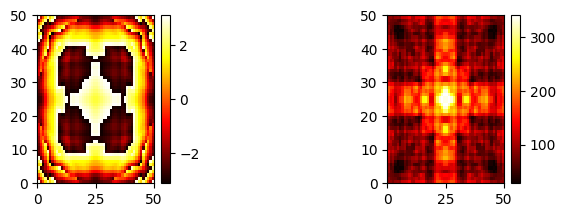

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 83.86it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 82.60it/s]


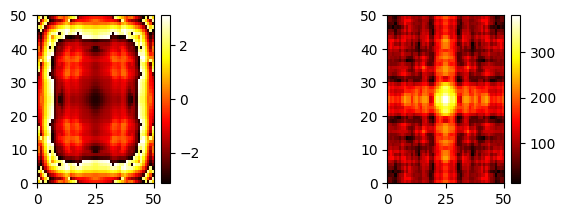

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.84it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.68it/s]


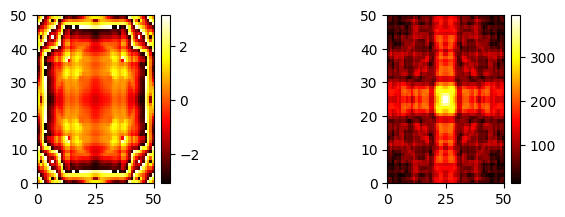

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.82it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 85.34it/s]


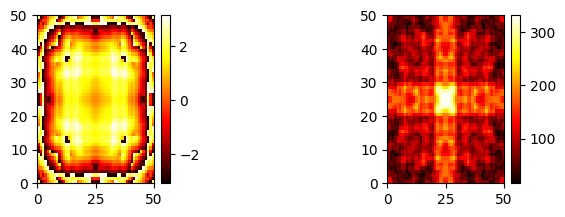

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 82.19it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 82.79it/s]


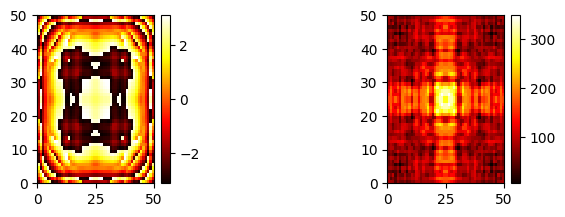

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.23it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.50it/s]


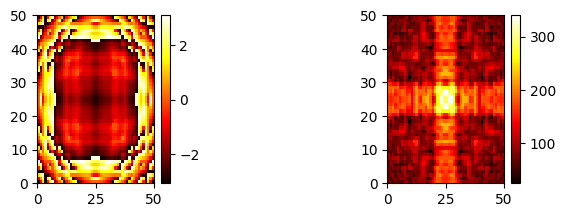

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.85it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 82.71it/s]


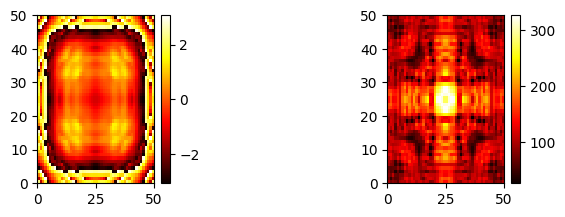

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 78.59it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.13it/s]


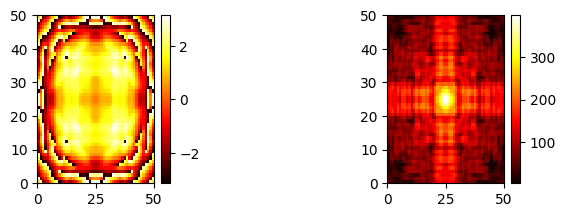

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.96it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.38it/s]


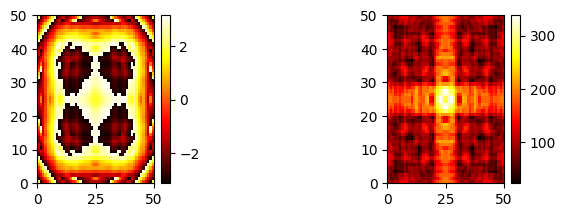

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.91it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 84.06it/s]


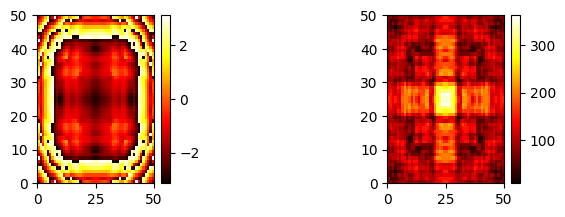

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.64it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 84.01it/s]


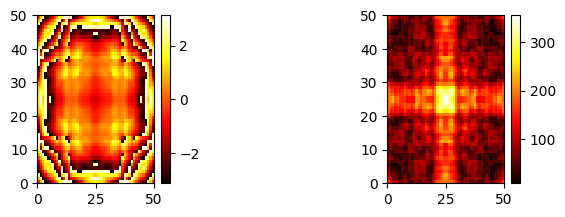

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 83.80it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.74it/s]


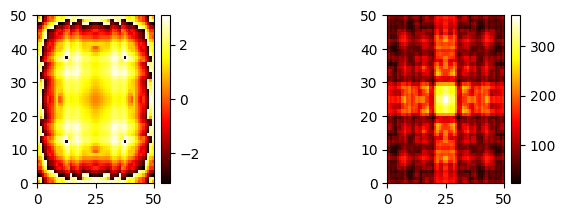

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.93it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 82.84it/s]


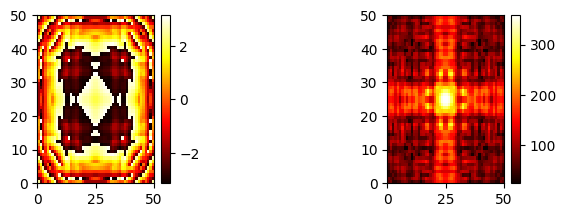

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.82it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 82.59it/s]


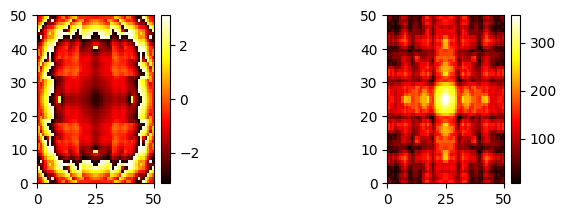

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 82.46it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 84.52it/s]


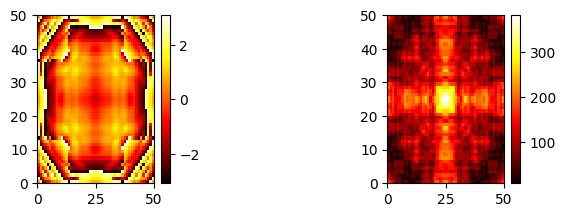

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 83.34it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 83.45it/s]


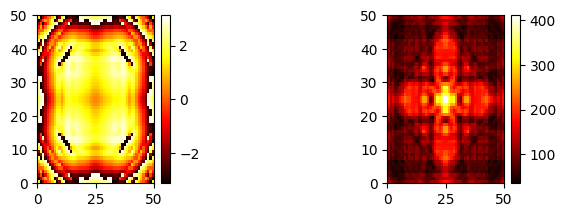

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 83.92it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 78.62it/s]


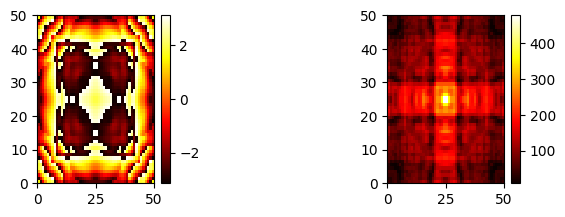

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 76.96it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.60it/s]


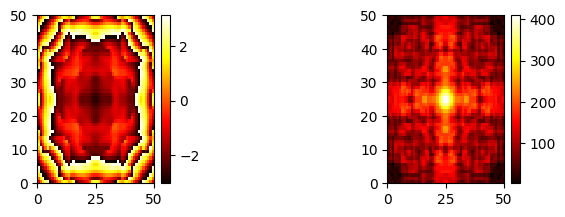

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.84it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 66.87it/s]


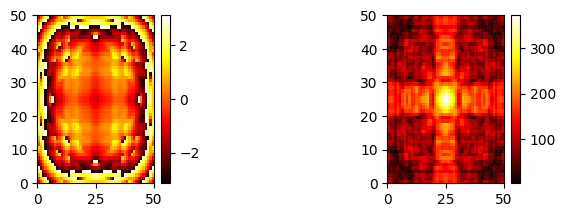

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.99it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.58it/s]


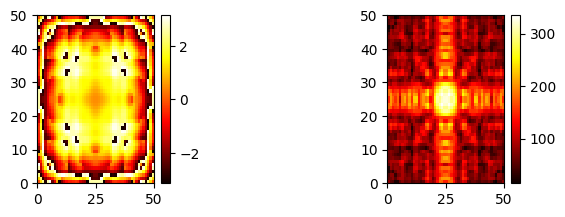

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.47it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.47it/s]


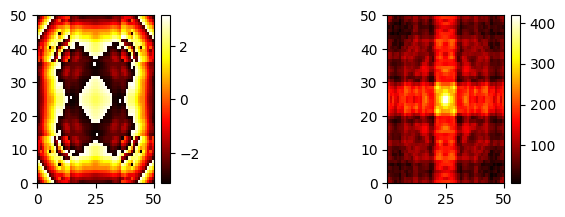

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 83.58it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.14it/s]


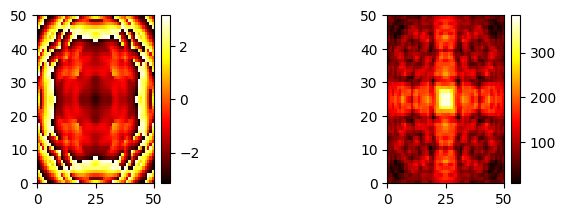

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.16it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.57it/s]


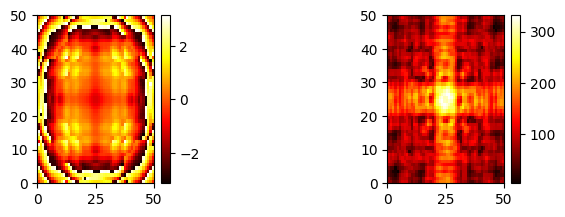

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.16it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.80it/s]


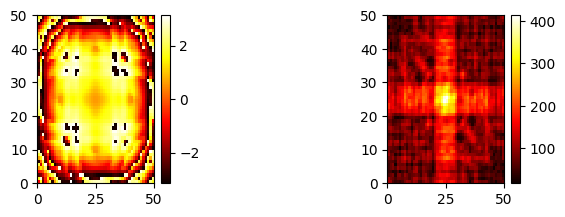

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.55it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.70it/s]


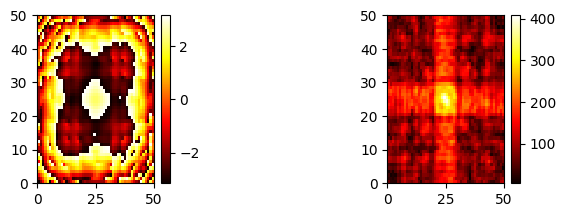

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.08it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 84.92it/s]


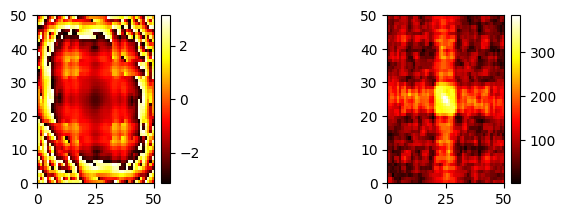

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.59it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.73it/s]


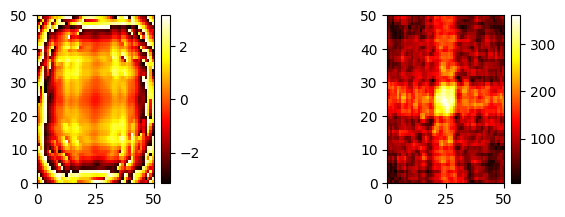

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.72it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.84it/s]


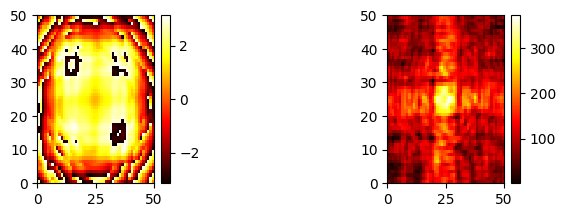

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.73it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 84.85it/s]


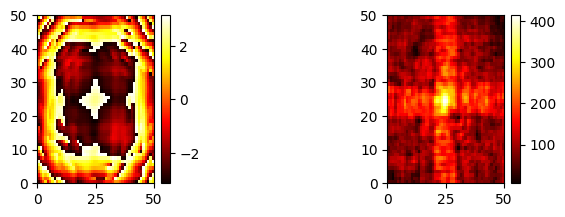

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 82.51it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.67it/s]


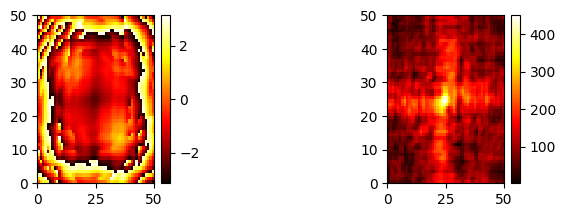

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 82.63it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.60it/s]


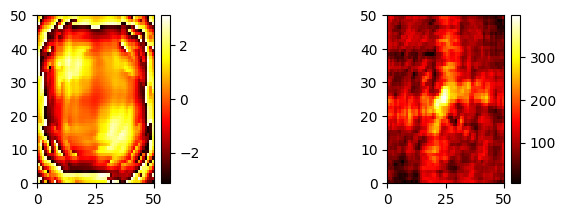

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.54it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 84.60it/s]


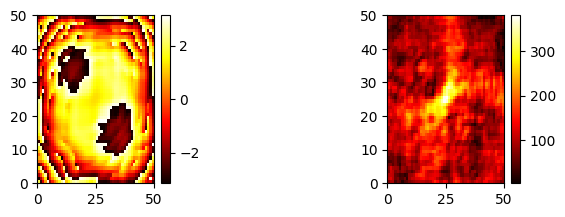

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.90it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 84.99it/s]


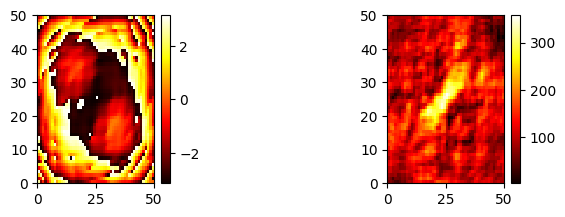

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.95it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 83.43it/s]


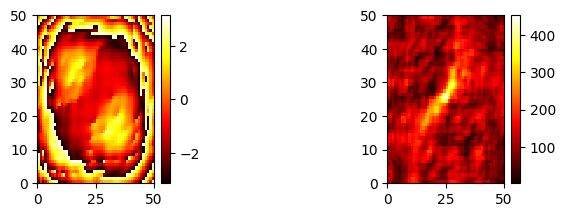

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 86.51it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.48it/s]


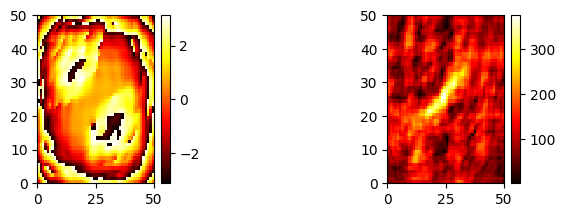

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.02it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.39it/s]


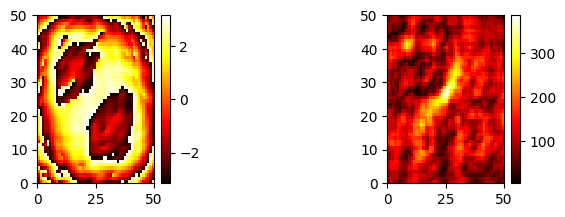

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.28it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 85.26it/s]


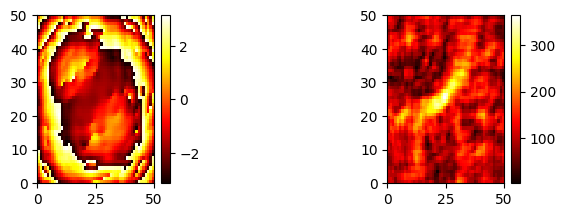

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.84it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 85.87it/s]


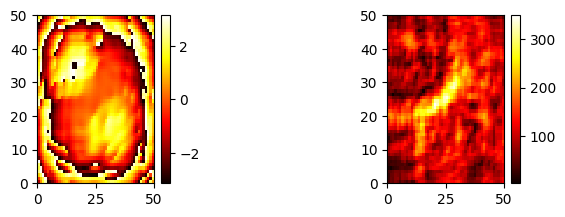

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.11it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 66.34it/s]


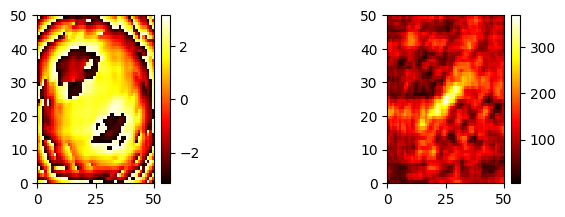

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.14it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.58it/s]


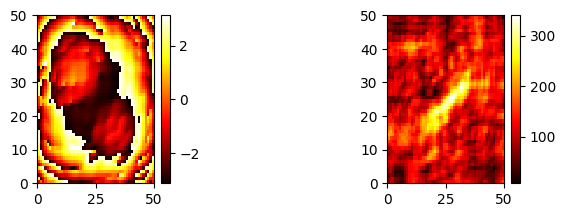

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.26it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 83.50it/s]


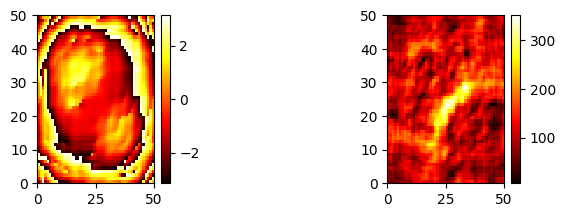

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 87.13it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 85.11it/s]


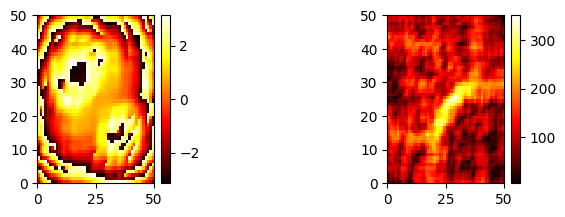

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.48it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 77.92it/s]


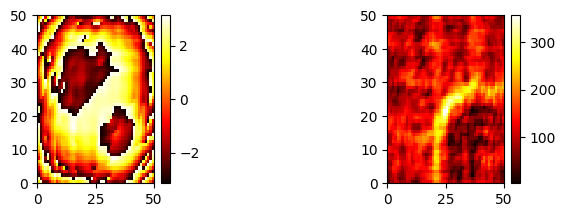

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.56it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.90it/s]


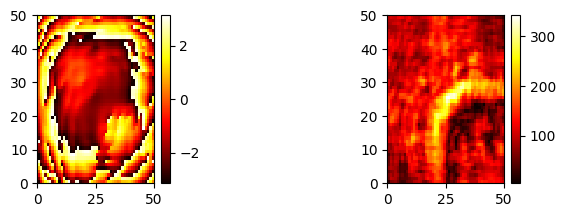

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.86it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.99it/s]


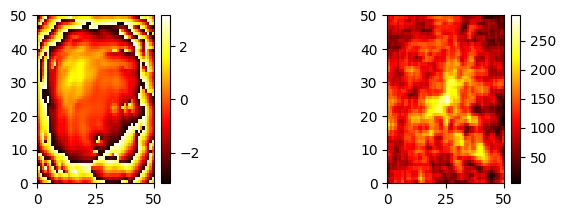

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.32it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.75it/s]


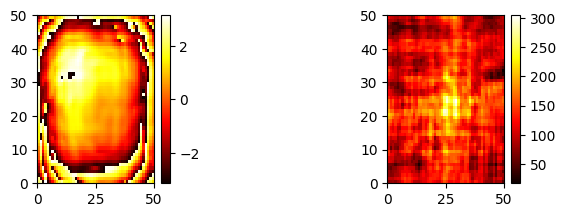

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 83.13it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 84.02it/s]


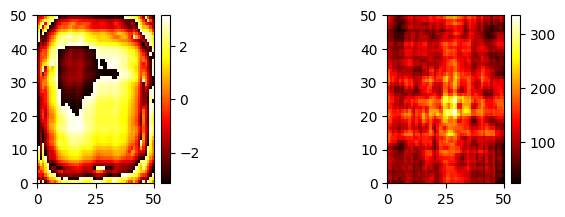

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 78.59it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.80it/s]


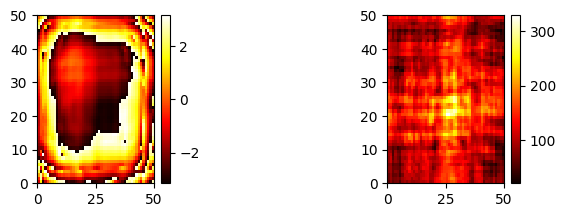

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 78.23it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 75.57it/s]


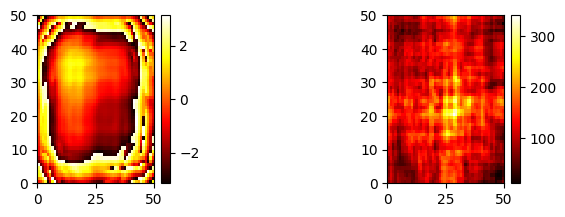

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 77.46it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 76.54it/s]


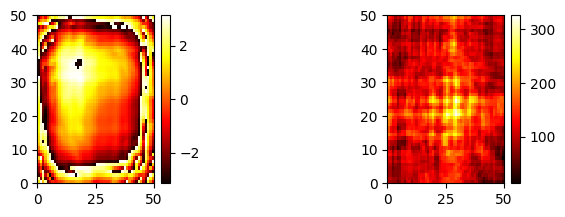

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.08it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.71it/s]


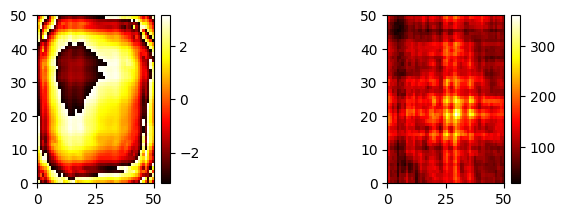

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 78.35it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 78.33it/s]


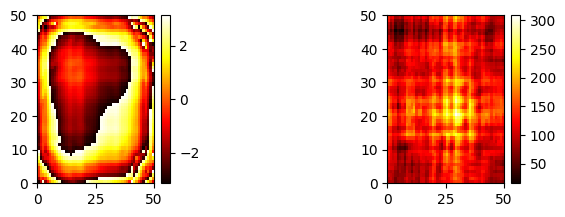

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.96it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.13it/s]


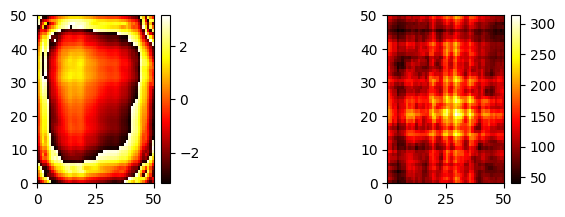

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 78.96it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.52it/s]


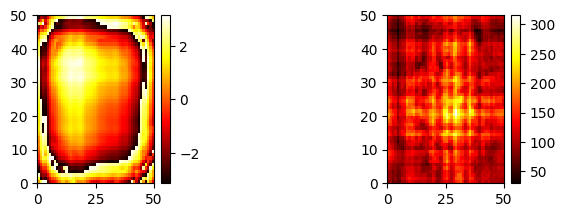

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.23it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.87it/s]


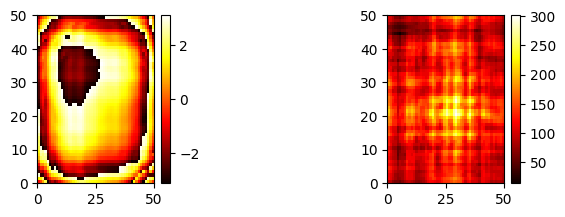

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.36it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 86.26it/s]


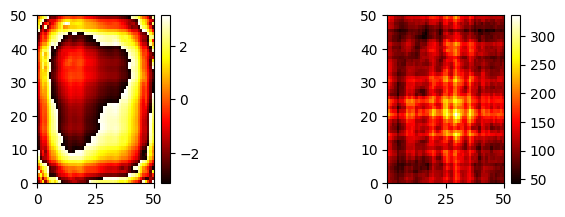

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 78.84it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.86it/s]


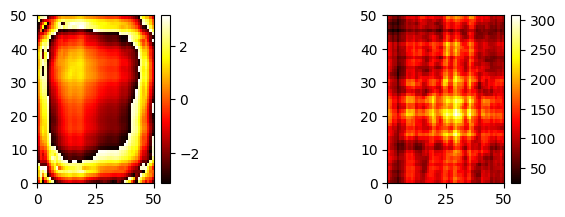

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.22it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.60it/s]


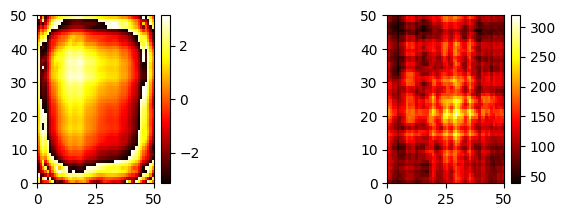

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 78.46it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.56it/s]


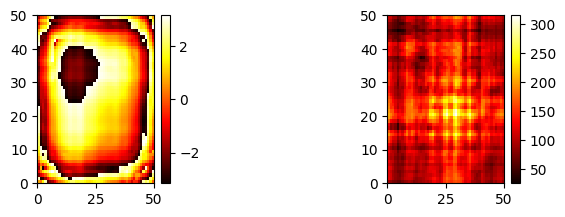

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.69it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 84.98it/s]


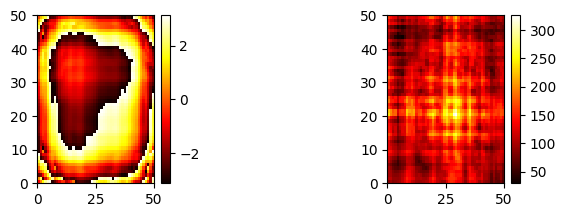

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 85.52it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 82.46it/s]


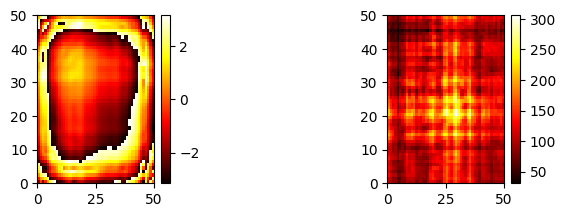

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 78.66it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.25it/s]


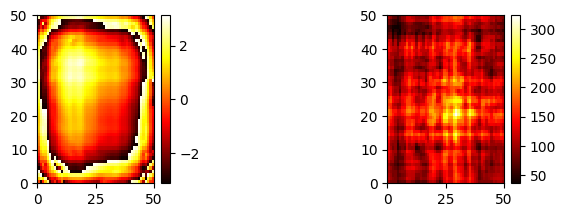

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.99it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.59it/s]


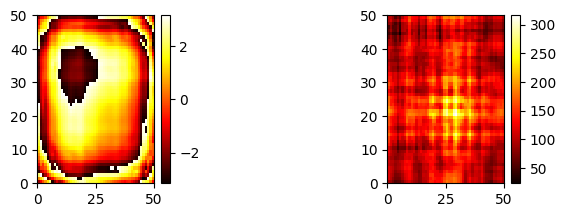

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.77it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 82.71it/s]


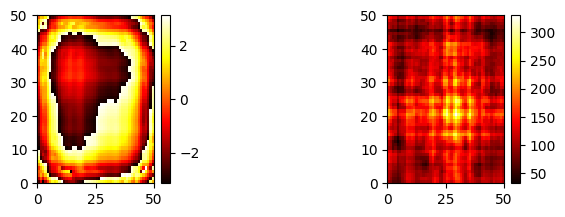

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.87it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.24it/s]


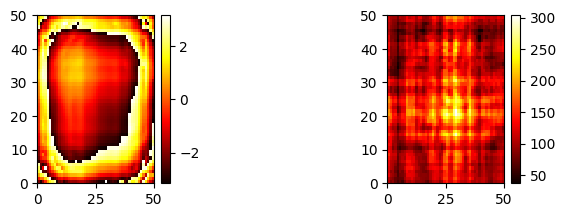

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 82.49it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.58it/s]


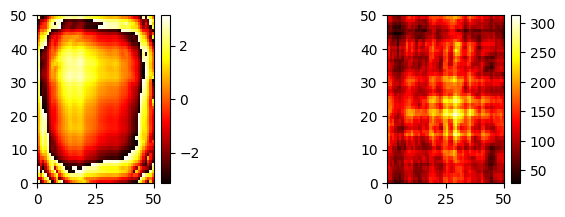

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 82.61it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.65it/s]


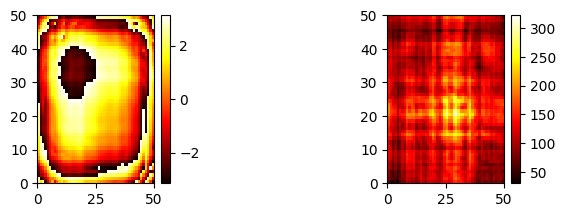

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.85it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.36it/s]


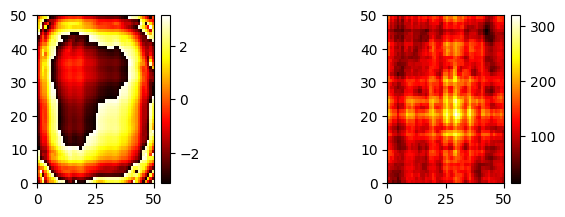

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.20it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 80.90it/s]


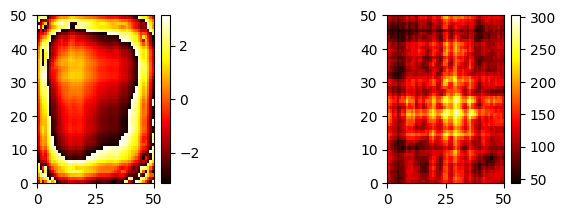

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 75.89it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 62.19it/s]


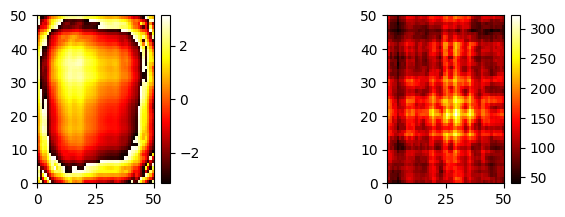

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.97it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 77.77it/s]


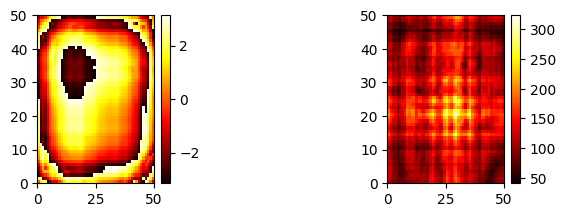

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 77.45it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 82.69it/s]


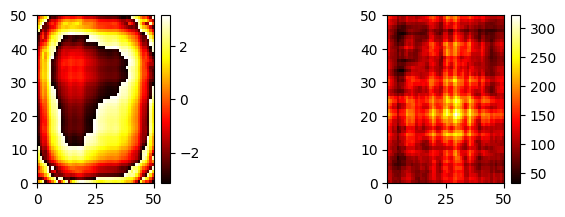

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.20it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.20it/s]


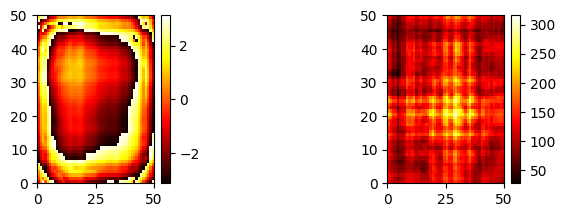

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.27it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.13it/s]


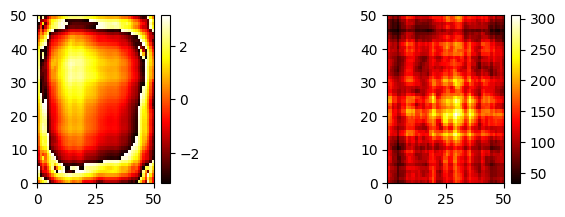

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.32it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 84.79it/s]


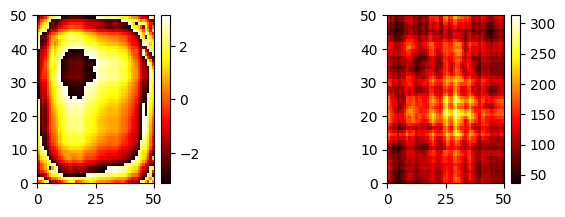

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.64it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.68it/s]


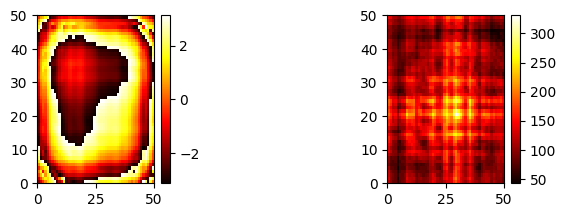

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.27it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 77.54it/s]


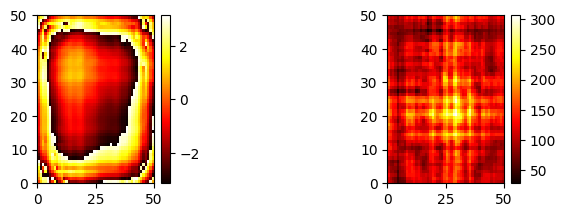

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 79.64it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.99it/s]


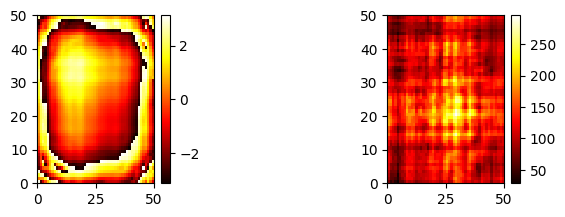

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 85.06it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 82.48it/s]


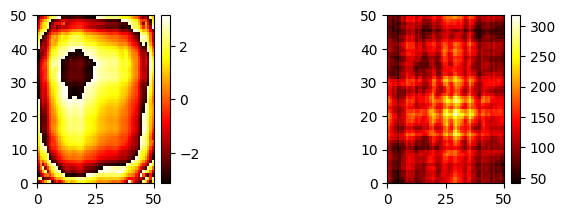

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 86.02it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 87.30it/s]


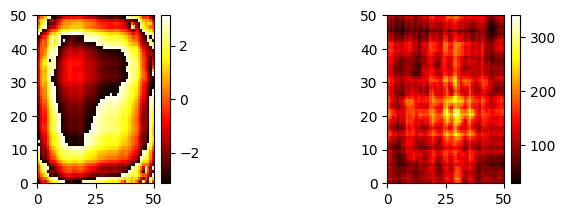

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 84.15it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 82.68it/s]


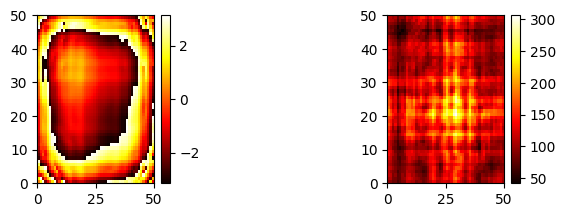

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 83.83it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 86.05it/s]


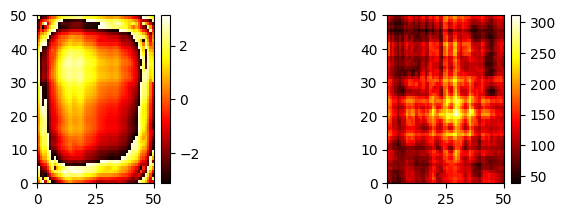

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 85.46it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 85.45it/s]


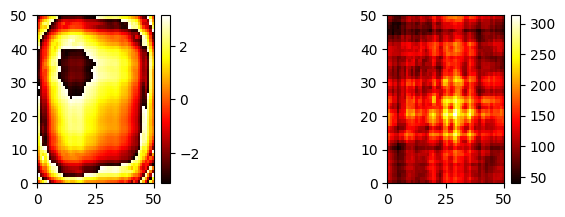

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 85.20it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 86.50it/s]


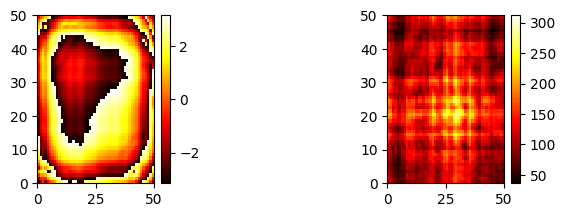

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 87.01it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 87.28it/s]


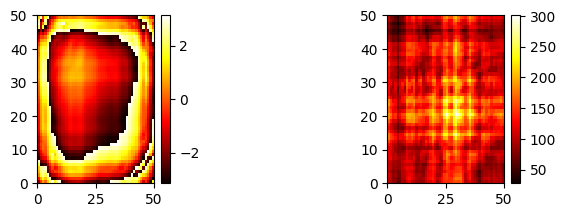

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 85.47it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 84.70it/s]


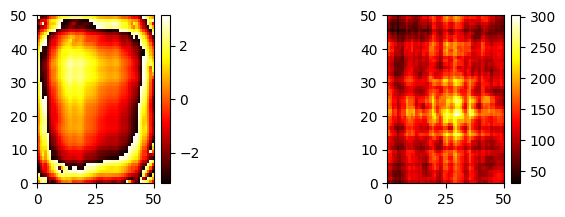

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.47it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 60.66it/s]


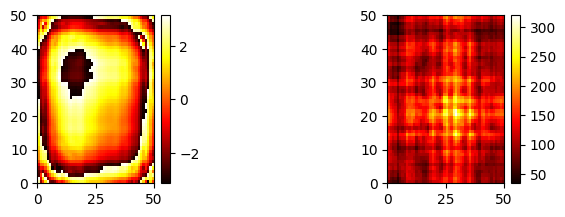

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 84.93it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 85.47it/s]


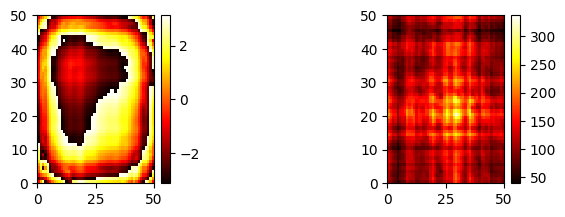

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 86.50it/s]

Propagating wavefront: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 86.48it/s]


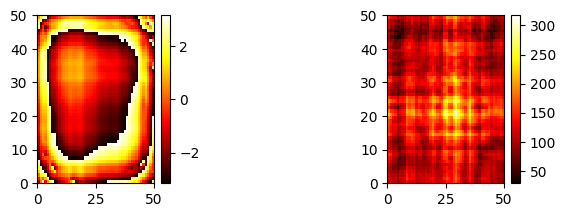

Gerchberg-Saxton Iterations: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:22<00:00,  1.42s/it]


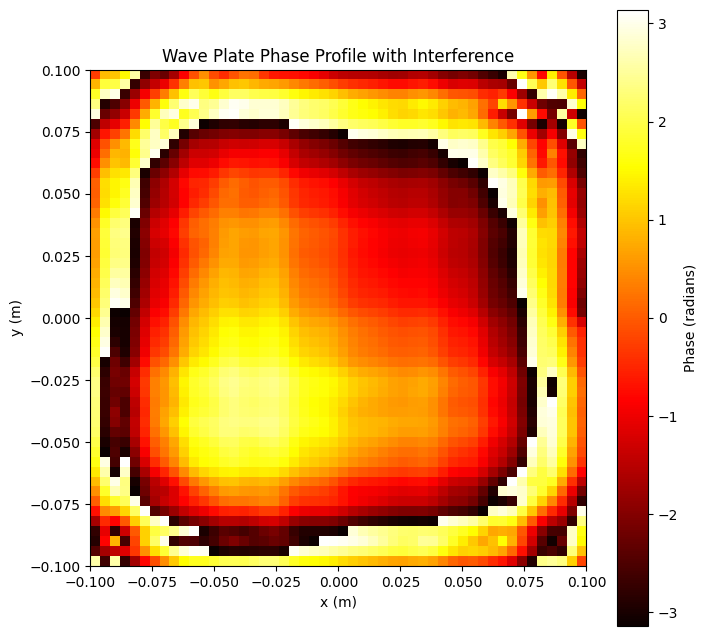

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Importing tqdm for progress reporting

# Constants
c = 3e8  # Speed of light (m/s)
freq = 97e9  # Frequency (Hz)
wavelength = c / freq  # Wavelength (meters)
k = 2 * np.pi / wavelength  # Wavenumber
distance = 0.5  # Distance from source to target (meters)
waveplate_size = 0.2  # Size of wave plate (in meters)
image_size=0.2


N = 50 # Number of grid points for wave plate and target

# Define coordinate system
x = np.linspace(-image_size / 2, image_size / 2, N)
y = np.linspace(-image_size / 2, image_size / 2, N)
X, Y = np.meshgrid(x, y)

 
# Target in a 20*20cm plane
x_target = np.linspace(-waveplate_size / 2, waveplate_size / 2, N)
y_target = np.linspace(-waveplate_size / 2, waveplate_size / 2, N)
X_target, Y_target = np.meshgrid(x_target, y_target)

target_size_x = 0.1  # Target size in x direction (meters)
target_size_y = 0.1  # Target size in y direction (meters)

target_amp = np.zeros_like(X_target)
target_amp[(np.abs(X_target) <= target_size_x / 2) & (np.abs(Y_target) <= target_size_y / 2)] = 1



#Initial beam
w0 = 0.5  # Beam waist (meters)
initial_amp = np.exp(-((X**2 + Y**2) / w0**2))  
initial_phase = np.zeros_like(initial_amp)  # make a flat phase
E_in = initial_amp * np.exp(1j * initial_phase)





# Define a function for Omega (phase or angular modulation)
def calculate_omega(rr, distance=0.5):
    
    
    z=distance
    cos_omega = z / rr
    
    # Calculate omega (angle in radians)
    omega = np.arccos(cos_omega)

    return omega

# Huygens-Fresnel propagation with interference
def propagate_with_interference(E_input):
    # N = E_input.shape[0]

    E_out = np.zeros((N, N), dtype=complex)
    
    for ix in tqdm(range(N), desc="Propagating wavefront"):
        for iy in range(N):
            r = np.sqrt((X_target - X[ix, iy])**2 + (Y_target - Y[ix, iy])**2 + distance**2)
            omega = calculate_omega(r)
           
        
            
            E_d=((np.abs(E_input[ix, iy]))/r)*(np.exp(((-1*1j)*k*r)+(1j*np.angle(E_input[ix, iy]))))
            # plt.pcolormesh((np.angle(E_d)), cmap='hot')
            # plt.title(str(ix)+'  '+str(iy))
            # plt.colorbar()
            # plt.show()
            

            E_out += E_d*(np.cos(omega))
            # plt.pcolormesh((np.angle(E_d)), cmap='hot')
            # plt.title(str(ix)+'  '+str(iy))
            # plt.colorbar()
            # plt.show()
            
      
    return E_out

# Gerchberg-Saxton iteration with interference
def gerchberg_saxton_with_interference(E_in, target_amp, iterations):
    # Start with the field at the waveplate with an initial phase of zero
    
    E_at_plate=E_in
    
    plt.subplot(1, 2, 1)
    plt.pcolormesh(np.abs(E_at_plate), cmap='hot')
    plt.subplot(1, 2, 2)
    plt.pcolormesh(np.angle(E_at_plate), cmap='hot')
    plt.colorbar()
    plt.show()


    for i in tqdm(range(iterations), desc="Gerchberg-Saxton Iterations"):
        # Step 1: Forward propagation to the target plane (image plane)
        
        plt.subplot(2, 3, 1)
        plt.pcolormesh(np.angle(E_at_plate), cmap='hot')
        plt.colorbar()
        # plt.subplot(2, 3, 2)
        # plt.pcolormesh(np.abs(E_at_plate), cmap='hot')
        # plt.colorbar()
        
        E_at_image = propagate_with_interference(E_at_plate)
        Phase_at_image=np.angle(E_at_image)
        
        plt.subplot(2, 3, 3)
        plt.pcolormesh(np.abs(E_at_image), cmap='hot')
        plt.colorbar()
        # plt.subplot(2, 3, 3)
        # plt.pcolormesh(np.angle(E_at_image), cmap='hot')



        
        E_at_image =  target_amp * np.exp(1j * Phase_at_image)
        
        # Step 3: Backward propagation to the phase plate (wave plate)
        E_at_plate = propagate_with_interference(E_at_image)
        
        
        # plt.subplot(2, 3, 4)
        # plt.pcolormesh(np.abs(E_at_plate), cmap ='hot')
        # plt.colorbar()
        # plt.subplot(2, 3, 3)
        # plt.pcolormesh(np.angle(E_at_plate), cmap ='hot')
        # plt.colorbar()


        
        Phase_at_plate=np.angle(E_at_plate)
        
        

        # Step 4: Update the phase at the wave plate (keep Gaussian amplitude, update phase)

        E_at_plate = initial_amp * np.exp(1j * Phase_at_plate)
  
                 
        
        plt.show()
    
    # Return the final phase of the waveplate
    return Phase_at_plate


# Run the Gerchberg-Saxton algorithm with interference
final_phase_with_interference = gerchberg_saxton_with_interference(E_in, target_amp, iterations=100)

# Visualize the updated phase profile
plt.figure(figsize=(8, 8))
plt.imshow(final_phase_with_interference, extent=[-waveplate_size / 2, waveplate_size / 2, -waveplate_size / 2, waveplate_size / 2], cmap='hot')
plt.colorbar(label='Phase (radians)')
plt.title('Wave Plate Phase Profile with Interference')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()
